# Alpha Parameter in Triplet Loss

Training Casia model with alpha=0.1
Epoch [1/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [2/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [3/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [4/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [5/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [6/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [7/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [8/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [9/10], Loss: 0.0580, Accuracy: 0.7725
Epoch [10/10], Loss: 0.0580, Accuracy: 0.7725
Training Casia model with alpha=0.3
Epoch [1/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [2/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [3/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [4/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [5/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [6/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [7/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [8/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [9/10], Loss: 0.1969, Accuracy: 0.7566
Epoch [10/10], Loss: 0.1969, Accuracy: 0.7566
Training Casia model with 

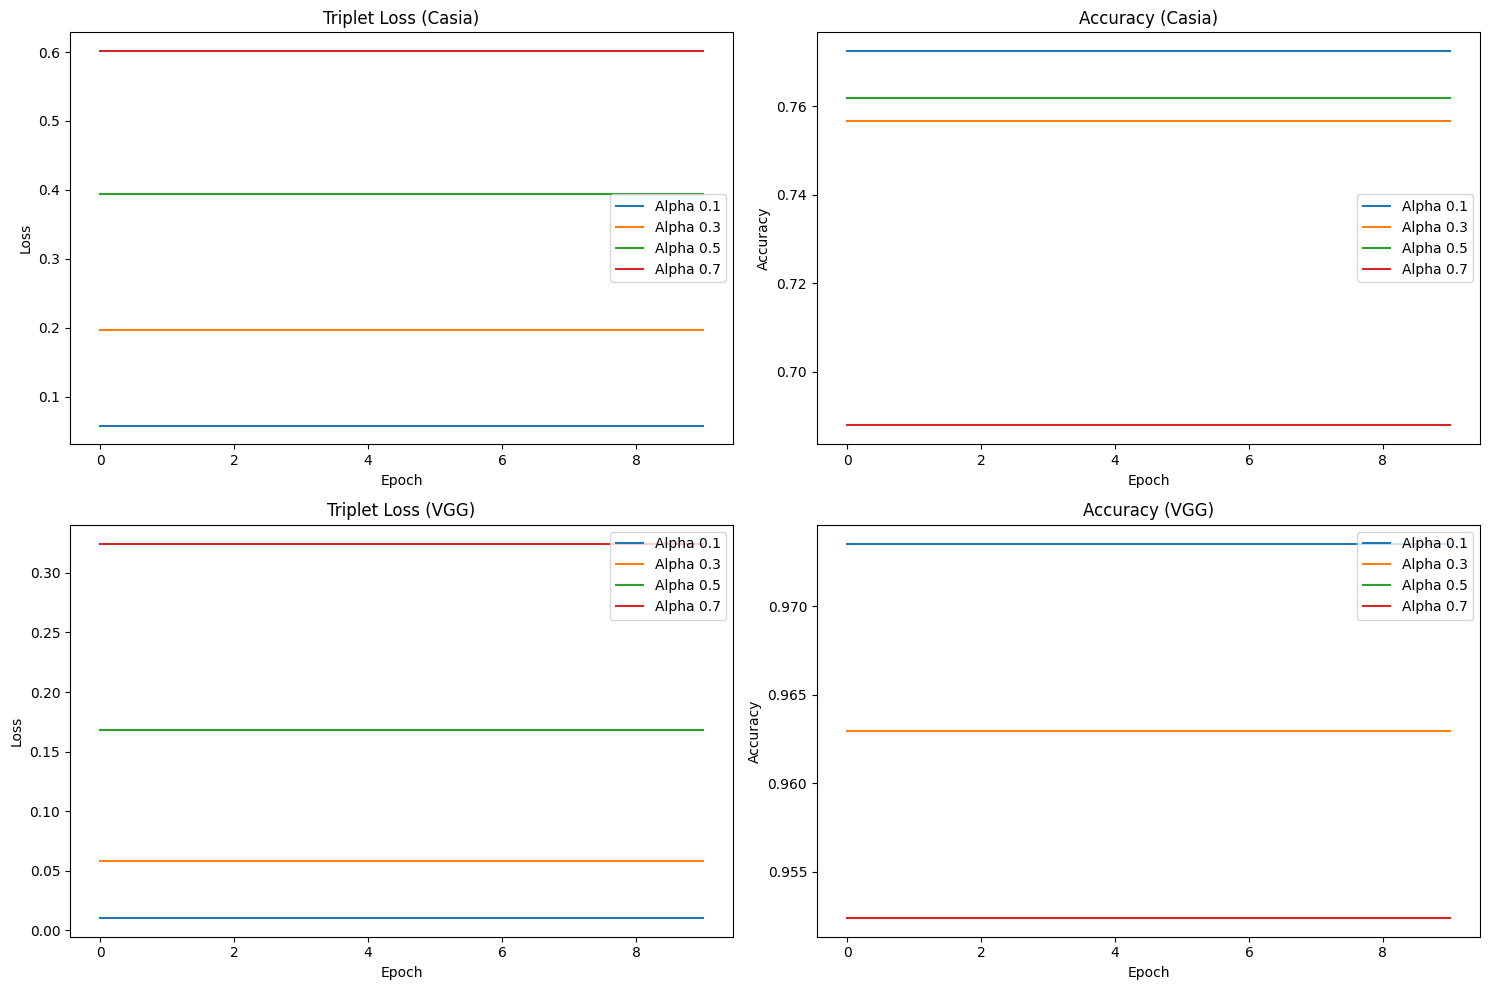

In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam
from pipeline import Pipeline
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Initialize the pipeline for both models (vggface2 and casia-webface)
casia_pipeline = Pipeline(pretrained='casia-webface', device='cpu')
vggface2_pipeline = Pipeline(pretrained='vggface2', device='cpu')

# Set up gallery directory path
gallery_dir = "storage/gallery"

# Load gallery images and labels from the directory
train_images = []
train_labels = []

# Update the label extraction to use the parent directory (identity name)
for root, _, files in os.walk(gallery_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._'):
            image_path = os.path.join(root, file)
            train_images.append(Image.open(image_path))
            identity_name = os.path.basename(os.path.dirname(image_path))  # Use the directory name as the label
            train_labels.append(identity_name)

# Define alpha values for analysis
alpha_values = [0.1, 0.3, 0.5, 0.7]

# Triplet Margin Loss function with configurable alpha (margin)
def triplet_loss_with_alpha(alpha):
    return nn.TripletMarginLoss(margin=alpha)

# Simulated training function for analyzing different alpha values
def train_model_with_alpha(pipeline, alpha, images, labels, epochs=10, learning_rate=0.001):
    # Extract embeddings for all images
    embeddings = [pipeline._encode(image) for image in images]
    embeddings = torch.tensor(embeddings, dtype=torch.float32, requires_grad=True)  # Set requires_grad=True

    # Prepare triplets (anchor, positive, negative)
    triplets = []
    for i in range(len(labels)):
        anchor = embeddings[i]
        
        # Find positive indices excluding the current anchor
        positive_indices = [j for j in range(len(labels)) if labels[j] == labels[i] and j != i]
        
        # If no positive example is found, skip this iteration
        if not positive_indices:
            continue
        
        positive_idx = np.random.choice(positive_indices)
        positive = embeddings[positive_idx]
        
        # Find negative indices (i.e., images with different labels)
        negative_indices = [j for j in range(len(labels)) if labels[j] != labels[i]]
        
        # If no negative example is found, skip this iteration
        if not negative_indices:
            continue
        
        negative_idx = np.random.choice(negative_indices)
        negative = embeddings[negative_idx]
        
        # Append the triplet to the triplets list
        triplets.append((anchor, positive, negative))

    # Convert triplets to tensors if triplets are available
    if len(triplets) == 0:
        print(f"No valid triplets found for alpha={alpha}. Skipping epoch.")
        return [], []

    # Convert triplets to tensors
    anchors = torch.stack([t[0] for t in triplets])
    positives = torch.stack([t[1] for t in triplets])
    negatives = torch.stack([t[2] for t in triplets])

    # Initialize optimizer
    optimizer = Adam([embeddings], lr=learning_rate)  # Use embeddings as a parameter for optimization
    
    # Triplet loss with given alpha
    criterion = triplet_loss_with_alpha(alpha)
    
    # Lists to store training loss and accuracy per epoch
    losses = []
    accuracies = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Calculate triplet loss
        loss = criterion(anchors, positives, negatives)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            distances_positive = torch.norm(anchors - positives, dim=1)
            distances_negative = torch.norm(anchors - negatives, dim=1)
            correct_predictions = torch.sum(distances_positive < distances_negative).item()
            accuracy = correct_predictions / len(anchors)
        
        # Store loss and accuracy
        losses.append(loss.item())
        accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    return losses, accuracies

# Placeholder for results
casia_results = []
vgg_results = []

# Analyze alpha for Casia model
for alpha in alpha_values:
    print(f"Training Casia model with alpha={alpha}")
    losses, accuracies = train_model_with_alpha(casia_pipeline, alpha, train_images, train_labels)
    casia_results.append((alpha, losses, accuracies))

# Analyze alpha for VGGFace2 model
for alpha in alpha_values:
    print(f"Training VGGFace2 model with alpha={alpha}")
    losses, accuracies = train_model_with_alpha(vggface2_pipeline, alpha, train_images, train_labels)
    vgg_results.append((alpha, losses, accuracies))

# Plotting results for comparison
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, alpha in enumerate(alpha_values):
    # Plot loss for Casia
    ax[0, 0].plot(casia_results[i][1], label=f'Alpha {alpha}')
    ax[0, 0].set_title('Triplet Loss (Casia)')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].legend()

    # Plot accuracy for Casia
    ax[0, 1].plot(casia_results[i][2], label=f'Alpha {alpha}')
    ax[0, 1].set_title('Accuracy (Casia)')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Accuracy')
    ax[0, 1].legend()

    # Plot loss for VGG
    ax[1, 0].plot(vgg_results[i][1], label=f'Alpha {alpha}')
    ax[1, 0].set_title('Triplet Loss (VGG)')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()

    # Plot accuracy for VGG
    ax[1, 1].plot(vgg_results[i][2], label=f'Alpha {alpha}')
    ax[1, 1].set_title('Accuracy (VGG)')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Accuracy')
    ax[1, 1].legend()

plt.tight_layout()
plt.show()

Training Casia model with alpha=0.1
Training Casia model with alpha=0.3
Training Casia model with alpha=0.5
Training Casia model with alpha=0.7
Training VGGFace2 model with alpha=0.1
Training VGGFace2 model with alpha=0.3
Training VGGFace2 model with alpha=0.5
Training VGGFace2 model with alpha=0.7


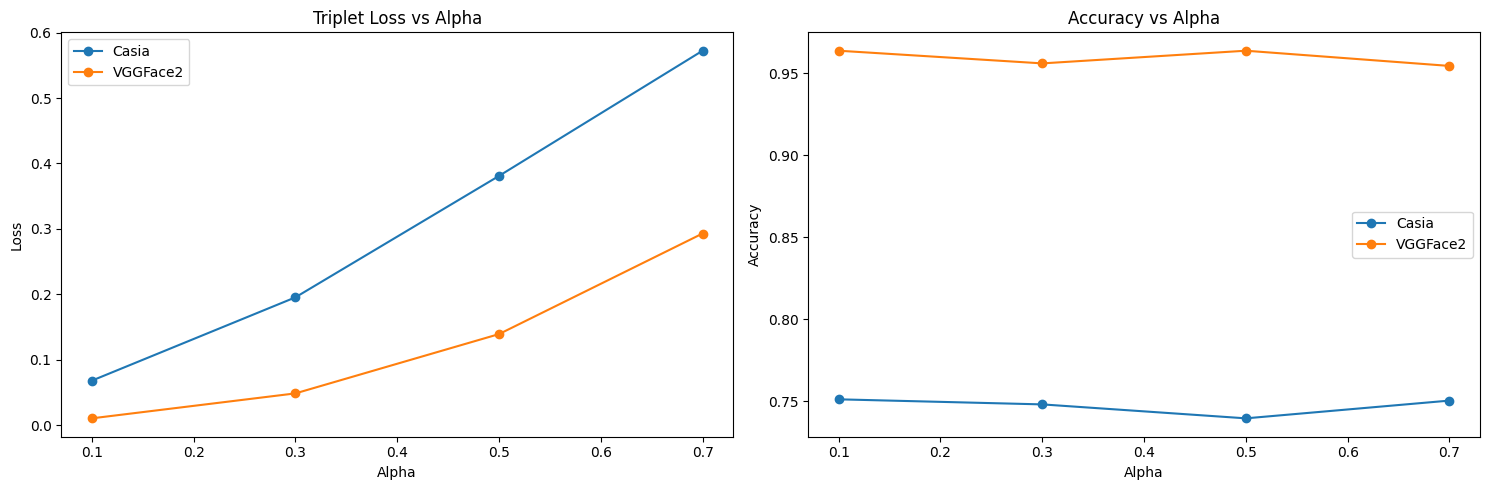

In [11]:
# Initialize the pipeline for both models (vggface2 and casia-webface)
casia_pipeline = Pipeline(pretrained='casia-webface', device='cpu')
vggface2_pipeline = Pipeline(pretrained='vggface2', device='cpu')

# Set up gallery directory path
gallery_dir = "storage/gallery"

# Load gallery images and labels from the directory
train_images = []
train_labels = []

# Update the label extraction to use the parent directory (identity name)
for root, _, files in os.walk(gallery_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._'):
            image_path = os.path.join(root, file)
            train_images.append(Image.open(image_path))
            identity_name = os.path.basename(os.path.dirname(image_path))  # Use the directory name as the label
            train_labels.append(identity_name)

# Define alpha values for analysis
alpha_values = [0.1, 0.3, 0.5, 0.7]

# Triplet Margin Loss function with configurable alpha (margin)
def triplet_loss_with_alpha(alpha):
    return nn.TripletMarginLoss(margin=alpha)

# Simulated training function for analyzing different alpha values
def train_model_with_alpha(pipeline, alpha, images, labels, learning_rate=0.001):
    # Extract embeddings for all images
    embeddings = [pipeline._encode(image) for image in images]
    embeddings = torch.tensor(embeddings, dtype=torch.float32, requires_grad=True)  # Set requires_grad=True

    # Prepare triplets (anchor, positive, negative)
    triplets = []
    for i in range(len(labels)):
        anchor = embeddings[i]
        
        # Find positive indices excluding the current anchor
        positive_indices = [j for j in range(len(labels)) if labels[j] == labels[i] and j != i]
        
        # If no positive example is found, skip this iteration
        if not positive_indices:
            continue
        
        positive_idx = np.random.choice(positive_indices)
        positive = embeddings[positive_idx]
        
        # Find negative indices (i.e., images with different labels)
        negative_indices = [j for j in range(len(labels)) if labels[j] != labels[i]]
        
        # If no negative example is found, skip this iteration
        if not negative_indices:
            continue
        
        negative_idx = np.random.choice(negative_indices)
        negative = embeddings[negative_idx]
        
        # Append the triplet to the triplets list
        triplets.append((anchor, positive, negative))

    # Convert triplets to tensors if triplets are available
    if len(triplets) == 0:
        print(f"No valid triplets found for alpha={alpha}. Skipping.")
        return None, None

    # Convert triplets to tensors
    anchors = torch.stack([t[0] for t in triplets])
    positives = torch.stack([t[1] for t in triplets])
    negatives = torch.stack([t[2] for t in triplets])

    # Initialize optimizer
    optimizer = Adam([embeddings], lr=learning_rate)
    
    # Triplet loss with given alpha
    criterion = triplet_loss_with_alpha(alpha)
    
    # Training loop (single epoch since we're evaluating alpha)
    optimizer.zero_grad()
    
    # Calculate triplet loss
    loss = criterion(anchors, positives, negatives)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        distances_positive = torch.norm(anchors - positives, dim=1)
        distances_negative = torch.norm(anchors - negatives, dim=1)
        correct_predictions = torch.sum(distances_positive < distances_negative).item()
        accuracy = correct_predictions / len(anchors)

    return loss.item(), accuracy

# Placeholder for results
casia_results = []
vgg_results = []

# Analyze alpha for Casia model
for alpha in alpha_values:
    print(f"Training Casia model with alpha={alpha}")
    loss, accuracy = train_model_with_alpha(casia_pipeline, alpha, train_images, train_labels)
    if loss is not None and accuracy is not None:
        casia_results.append((alpha, loss, accuracy))

# Analyze alpha for VGGFace2 model
for alpha in alpha_values:
    print(f"Training VGGFace2 model with alpha={alpha}")
    loss, accuracy = train_model_with_alpha(vggface2_pipeline, alpha, train_images, train_labels)
    if loss is not None and accuracy is not None:
        vgg_results.append((alpha, loss, accuracy))

# Separate alpha, loss, and accuracy for plotting
casia_alphas, casia_losses, casia_accuracies = zip(*casia_results)
vgg_alphas, vgg_losses, vgg_accuracies = zip(*vgg_results)

# Plotting results for comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss for Casia and VGG
ax[0].plot(casia_alphas, casia_losses, label='Casia', marker='o')
ax[0].plot(vgg_alphas, vgg_losses, label='VGGFace2', marker='o')
ax[0].set_title('Triplet Loss vs Alpha')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot accuracy for Casia and VGG
ax[1].plot(casia_alphas, casia_accuracies, label='Casia', marker='o')
ax[1].plot(vgg_alphas, vgg_accuracies, label='VGGFace2', marker='o')
ax[1].set_title('Accuracy vs Alpha')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

# Number of Images per Employee

Analyzing with 1 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 2 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 3 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 4 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 5 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 6 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 7 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 8 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 9 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

Analyzing with 10 images per employee


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all

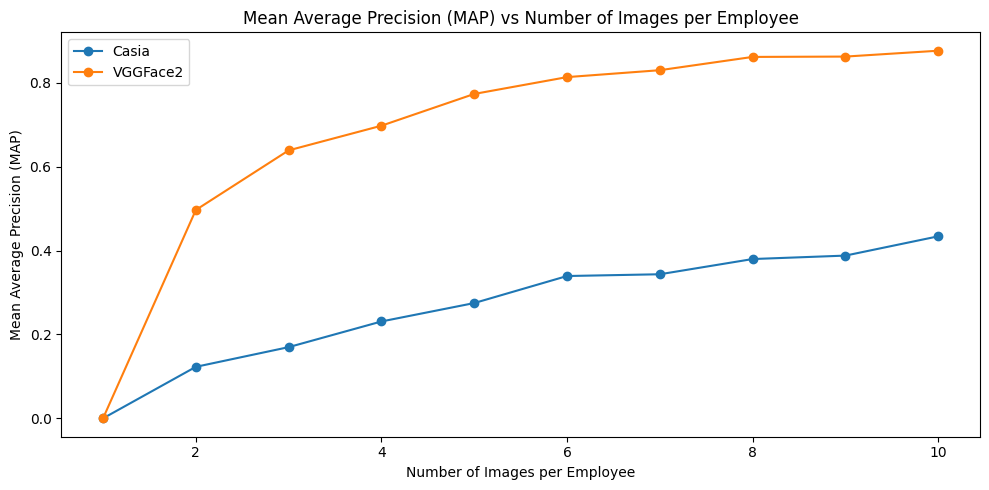

In [7]:
import torch
import numpy as np
import random
from sklearn.metrics import average_precision_score
from pipeline import Pipeline
from PIL import Image
import os
import matplotlib.pyplot as plt

# Initialize the pipeline for both models (vggface2 and casia-webface)
casia_pipeline = Pipeline(pretrained='casia-webface', device='cpu')
vggface2_pipeline = Pipeline(pretrained='vggface2', device='cpu')

# Set up gallery directory path
gallery_dir = "storage/gallery"

# Load gallery images and labels from the directory
gallery_images = []
gallery_labels = []

for root, _, files in os.walk(gallery_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._'):
            image_path = os.path.join(root, file)
            gallery_images.append(Image.open(image_path))
            identity_name = os.path.basename(os.path.dirname(image_path))
            gallery_labels.append(identity_name)

# Group images by identity
identity_to_images = {}
for image, label in zip(gallery_images, gallery_labels):
    if label not in identity_to_images:
        identity_to_images[label] = []
    identity_to_images[label].append(image)

# Get the unique counts of images per employee and sort them
num_images_per_employee_values = sorted(set(len(images) for images in identity_to_images.values()))

# Define system parameter k for k-nearest neighbors search
k = 5

# Helper function to sample images per employee
def sample_images_per_employee(images, labels, num_samples):
    sampled_images = []
    sampled_labels = []
    
    # Group images by identity
    identity_to_images = {}
    for image, label in zip(images, labels):
        if label not in identity_to_images:
            identity_to_images[label] = []
        identity_to_images[label].append(image)
    
    # Sample images for each identity
    for label, image_list in identity_to_images.items():
        if len(image_list) >= num_samples:
            sampled = random.sample(image_list, num_samples)
            sampled_images.extend(sampled)
            sampled_labels.extend([label] * num_samples)
    
    return sampled_images, sampled_labels

# Placeholder for results
casia_results = []
vgg_results = []

# Analyze the effect of the number of images per employee
for num_images in num_images_per_employee_values:
    print(f"Analyzing with {num_images} images per employee")
    
    # Sample images for analysis
    sampled_images, sampled_labels = sample_images_per_employee(gallery_images, gallery_labels, num_images)
    
    # Extract embeddings for Casia model
    casia_embeddings = [casia_pipeline._encode(image) for image in sampled_images]
    casia_embeddings = torch.tensor(casia_embeddings, dtype=torch.float32)
    
    # Extract embeddings for VGGFace2 model
    vgg_embeddings = [vggface2_pipeline._encode(image) for image in sampled_images]
    vgg_embeddings = torch.tensor(vgg_embeddings, dtype=torch.float32)
    
    # Calculate AP@k and MAP for Casia
    casia_ap_scores = []
    for i in range(len(casia_embeddings)):
        distances = torch.norm(casia_embeddings - casia_embeddings[i], dim=1)
        sorted_indices = torch.argsort(distances)
        top_k_indices = sorted_indices[1:k+1]  # Exclude the query itself
        top_k_labels = [sampled_labels[idx] for idx in top_k_indices]
        true_labels = [1 if label == sampled_labels[i] else 0 for label in top_k_labels]
        casia_ap_scores.append(average_precision_score(true_labels, -distances[top_k_indices].numpy()))
    casia_map = np.mean(casia_ap_scores)
    casia_results.append((num_images, casia_map))
    
    # Calculate AP@k and MAP for VGGFace2
    vgg_ap_scores = []
    for i in range(len(vgg_embeddings)):
        distances = torch.norm(vgg_embeddings - vgg_embeddings[i], dim=1)
        sorted_indices = torch.argsort(distances)
        top_k_indices = sorted_indices[1:k+1]  # Exclude the query itself
        top_k_labels = [sampled_labels[idx] for idx in top_k_indices]
        true_labels = [1 if label == sampled_labels[i] else 0 for label in top_k_labels]
        vgg_ap_scores.append(average_precision_score(true_labels, -distances[top_k_indices].numpy()))
    vgg_map = np.mean(vgg_ap_scores)
    vgg_results.append((num_images, vgg_map))

# Plotting results for comparison
fig, ax = plt.subplots(figsize=(10, 5))

casia_num_images, casia_maps = zip(*casia_results)
vgg_num_images, vgg_maps = zip(*vgg_results)

ax.plot(casia_num_images, casia_maps, marker='o', label='Casia')
ax.plot(vgg_num_images, vgg_maps, marker='o', label='VGGFace2')

ax.set_title('Mean Average Precision (MAP) vs Number of Images per Employee')
ax.set_xlabel('Number of Images per Employee')
ax.set_ylabel('Mean Average Precision (MAP)')
ax.legend()

plt.tight_layout()
plt.show()

# System Parameter k for k-Nearest Neighbors Search

Processed: storage/gallery/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
Processed: storage/gallery/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
Processed: storage/gallery/Abdullah/Abdullah_0001.jpg
Processed: storage/gallery/Abdullah/Abdullah_0002.jpg
Processed: storage/gallery/Abdullah/Abdullah_0003.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0001.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0002.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0003.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0004.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0005.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0006.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0007.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0008.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0009.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0010.jpg
Processed: storage/gallery/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0001.jpg
Proc

2024-10-25 21:59:50,780 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:50,781 - INFO - Found 1 results
2024-10-25 21:59:51,107 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:51,108 - INFO - Found 1 results
2024-10-25 21:59:51,386 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:51,388 - INFO - Found 1 results
2024-10-25 21:59:51,655 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:51,656 - INFO - Found 1 results
2024-10-25 21:59:51,926 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:51,928 - INFO - Found 1 results
2024-10-25 21:59:52,282 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:52,283 - INFO - Found 1 results
2024-10-25 21:59:52,556 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:52,558 - INFO - Found 1 results
2024-10-25 21:59:52,822 - INFO - Searching for 1 nearest neighbors
2024-10-25 21:59:52,823 - INFO - Found 1 results
2024-10-25 21:59:53,115 - INFO - Searching for 1 nearest neighbors
2024-

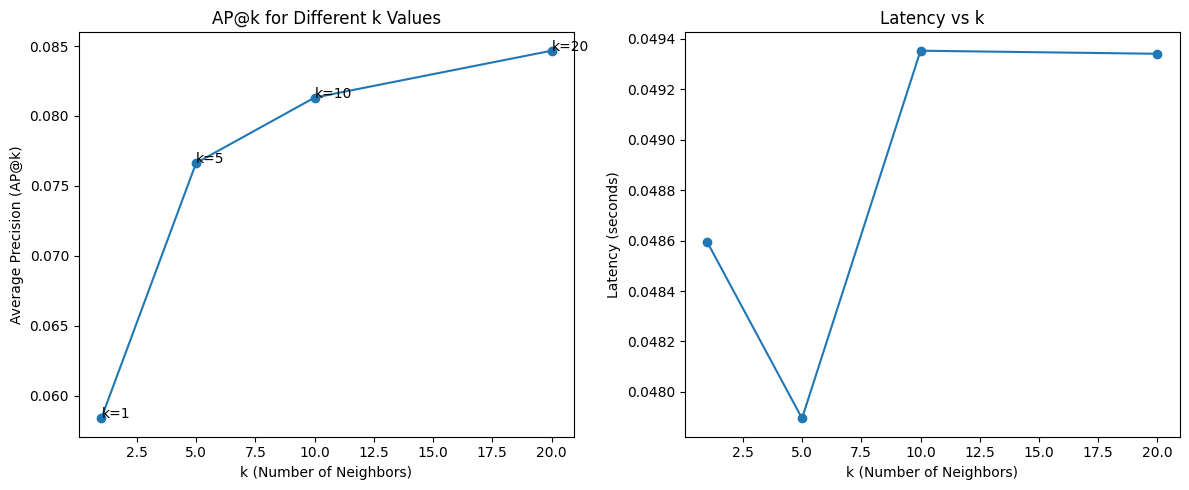

In [3]:
import matplotlib.pyplot as plt
import time
import numpy as np
import os
from PIL import Image
import random
from pipeline import Pipeline

random.seed(42)
np.random.seed(42)

class FaissSearchAnalyzer:
    def __init__(self, pipeline, gallery_dir, probe_dir, k_values):
        self.pipeline = pipeline
        self.gallery_dir = gallery_dir
        self.probe_dir = probe_dir
        self.k_values = k_values
        self.results = {}

    def run_analysis(self):
        # Build the index for the gallery
        self.pipeline.build_gallery_index(self.gallery_dir)
        self.pipeline.load_gallery_index()

        # Get all probe image paths
        probe_paths = [
            os.path.join(root, file)
            for root, _, files in os.walk(self.probe_dir)
            for file in files
            if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._')
        ]

        # Iterate through each value of k and measure the metrics
        for k in self.k_values:
            ap_list = []
            latencies = []

            for probe_path in probe_paths:
                probe_image = Image.open(probe_path)
                # Start timing the search
                start_time = time.time()
                results = self.pipeline.search_gallery(probe_image, k=k)
                elapsed_time = time.time() - start_time
                latencies.append(elapsed_time)

                ground_truth = os.path.basename(os.path.dirname(probe_path))
                retrieved_labels = [result['name'] for result in results]

                # Compute AP@k manually
                num_relevant = 0
                precisions = []

                for i, label in enumerate(retrieved_labels):
                    if ground_truth == label:
                        num_relevant += 1
                        precision_at_i = num_relevant / (i + 1)
                        precisions.append(precision_at_i)

                total_relevant_items = self._num_relevant_in_gallery(ground_truth)
                if precisions:
                    ap = np.sum(precisions) / total_relevant_items
                else:
                    ap = 0.0

                ap_list.append(ap)

            # Average AP@k and latency across all probes
            avg_ap = np.mean(ap_list)
            avg_latency = np.mean(latencies)

            self.results[k] = {
                'ap': avg_ap,
                'latency': avg_latency
            }

    def _num_relevant_in_gallery(self, ground_truth_label):
        count = 0
        for root, _, files in os.walk(self.gallery_dir):
            label = os.path.basename(root)
            if label == ground_truth_label:
                count += len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._')])
        return count

    def plot_results(self):
        # Plot AP@k for different k values
        plt.figure(figsize=(12, 5))
        aps = [self.results[k]['ap'] for k in self.k_values]

        plt.subplot(1, 2, 1)
        plt.plot(self.k_values, aps, marker='o')
        plt.xlabel('k (Number of Neighbors)')
        plt.ylabel('Average Precision (AP@k)')
        plt.title('AP@k for Different k Values')
        for i, k in enumerate(self.k_values):
            plt.annotate(f'k={k}', (self.k_values[i], aps[i]))

        # Plot Latency vs k
        plt.subplot(1, 2, 2)
        latencies = [self.results[k]['latency'] for k in self.k_values]
        plt.plot(self.k_values, latencies, marker='o')
        plt.xlabel('k (Number of Neighbors)')
        plt.ylabel('Latency (seconds)')
        plt.title('Latency vs k')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    pipeline = Pipeline()
    gallery_dir = 'storage/gallery'
    probe_dir = 'simclr_resources/probe'
    k_values = [1, 5, 10, 20]

    # Run the k-NN analysis
    analyzer = FaissSearchAnalyzer(pipeline, gallery_dir, probe_dir, k_values)
    analyzer.run_analysis()
    analyzer.plot_results()

# Indexing Type (Flat vs. HNSW)

Running analysis for index type: Flat
Processed: storage/gallery/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
Processed: storage/gallery/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
Processed: storage/gallery/Abdullah/Abdullah_0001.jpg
Processed: storage/gallery/Abdullah/Abdullah_0002.jpg
Processed: storage/gallery/Abdullah/Abdullah_0003.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0001.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0002.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0003.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0004.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0005.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0006.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0007.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0008.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0009.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0010.jpg
Processed: storage/gallery/Abdullah_al-Att

2024-10-26 01:46:28,226 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,227 - INFO - Found 1 results
2024-10-26 01:46:28,281 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,282 - INFO - Found 1 results
2024-10-26 01:46:28,338 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,339 - INFO - Found 1 results


Processed: storage/gallery/Zoran_Djindjic/Zoran_Djindjic_0003.jpg


2024-10-26 01:46:28,408 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,409 - INFO - Found 1 results
2024-10-26 01:46:28,460 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,462 - INFO - Found 1 results
2024-10-26 01:46:28,520 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,522 - INFO - Found 1 results
2024-10-26 01:46:28,584 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,586 - INFO - Found 1 results
2024-10-26 01:46:28,643 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,644 - INFO - Found 1 results
2024-10-26 01:46:28,703 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,705 - INFO - Found 1 results
2024-10-26 01:46:28,762 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,764 - INFO - Found 1 results
2024-10-26 01:46:28,821 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:46:28,822 - INFO - Found 1 results
2024-10-26 01:46:28,879 - INFO - Searching for 1 nearest neighbors
2024-

Running analysis for index type: HNSW
Processed: storage/gallery/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
Processed: storage/gallery/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
Processed: storage/gallery/Abdullah/Abdullah_0001.jpg
Processed: storage/gallery/Abdullah/Abdullah_0002.jpg
Processed: storage/gallery/Abdullah/Abdullah_0003.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0001.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0002.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0003.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0004.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0005.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0006.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0007.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0008.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0009.jpg
Processed: storage/gallery/Abdullah_Gul/Abdullah_Gul_0010.jpg
Processed: storage/gallery/Abdullah_al-Att

2024-10-26 01:51:03,191 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,192 - INFO - Found 1 results
2024-10-26 01:51:03,233 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,234 - INFO - Found 1 results
2024-10-26 01:51:03,274 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,275 - INFO - Found 1 results
2024-10-26 01:51:03,316 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,317 - INFO - Found 1 results
2024-10-26 01:51:03,365 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,366 - INFO - Found 1 results
2024-10-26 01:51:03,423 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,429 - INFO - Found 1 results
2024-10-26 01:51:03,495 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,496 - INFO - Found 1 results
2024-10-26 01:51:03,551 - INFO - Searching for 1 nearest neighbors
2024-10-26 01:51:03,552 - INFO - Found 1 results
2024-10-26 01:51:03,610 - INFO - Searching for 1 nearest neighbors
2024-

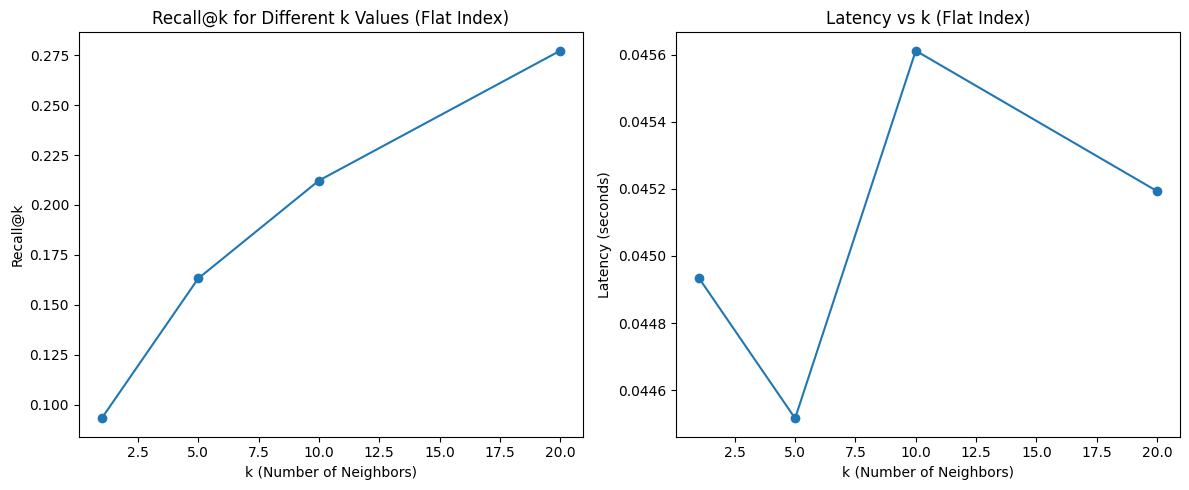

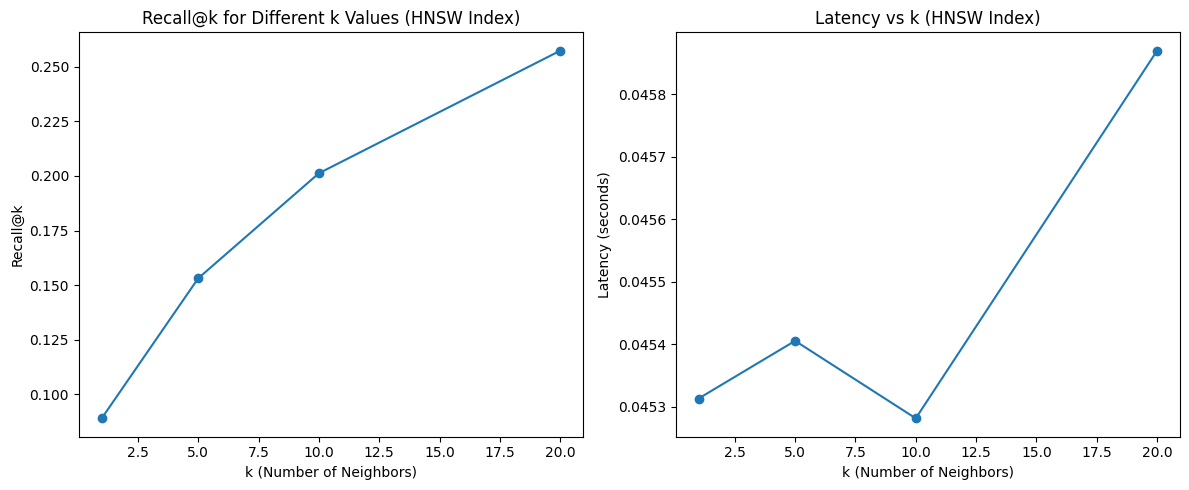

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pipeline import Pipeline
from sklearn.metrics import recall_score
import os
from PIL import Image

class IndexTypeAnalyzer:
    def __init__(self, index_types, gallery_dir, probe_dir, k_values):
        self.index_types = index_types
        self.gallery_dir = gallery_dir
        self.probe_dir = probe_dir
        self.k_values = k_values
        self.results = {index_type: {'recall': [], 'latency': []} for index_type in index_types}

    def run_analysis(self):
        probe_paths = [
            os.path.join(root, file)
            for root, _, files in os.walk(self.probe_dir)
            for file in files
            if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._')
        ]

        for index_type in self.index_types:
            print(f"Running analysis for index type: {index_type}")
            pipeline = Pipeline(index_type=index_type)
            pipeline.build_gallery_index(self.gallery_dir)
            pipeline.load_gallery_index()

            for k in self.k_values:
                recall_list = []
                latencies = []

                for probe_path in probe_paths:
                    probe_image = Image.open(probe_path)
                    start_time = time.time()
                    results = pipeline.search_gallery(probe_image, k=k)
                    elapsed_time = time.time() - start_time
                    latencies.append(elapsed_time)

                    ground_truth = os.path.basename(os.path.dirname(probe_path))
                    retrieved_labels = [result['name'] for result in results]

                    # Compute recall@k
                    recall_at_k = self._compute_recall_at_k(ground_truth, retrieved_labels)
                    recall_list.append(recall_at_k)

                # Average recall@k and latency across all probes
                avg_recall = np.mean(recall_list)
                avg_latency = np.mean(latencies)

                self.results[index_type]['recall'].append(avg_recall)
                self.results[index_type]['latency'].append(avg_latency)

    def _compute_recall_at_k(self, ground_truth, retrieved_labels):
        return 1 if ground_truth in retrieved_labels else 0

    def plot_results(self):
        for index_type in self.index_types:
            plt.figure(figsize=(12, 5))

            # Plot Recall@k for different k values
            plt.subplot(1, 2, 1)
            recall_values = self.results[index_type]['recall']
            plt.plot(self.k_values, recall_values, marker='o')
            plt.xlabel('k (Number of Neighbors)')
            plt.ylabel('Recall@k')
            plt.title(f'Recall@k for Different k Values ({index_type} Index)')

            # Plot Latency vs k
            plt.subplot(1, 2, 2)
            latencies = self.results[index_type]['latency']
            plt.plot(self.k_values, latencies, marker='o')
            plt.xlabel('k (Number of Neighbors)')
            plt.ylabel('Latency (seconds)')
            plt.title(f'Latency vs k ({index_type} Index)')

            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    gallery_dir = 'storage/gallery'
    probe_dir = 'simclr_resources/probe'
    index_types = ['Flat', 'HNSW']
    k_values = [1, 5, 10, 20]

    analyzer = IndexTypeAnalyzer(index_types, gallery_dir, probe_dir, k_values)
    analyzer.run_analysis()
    analyzer.plot_results()